In [1]:
%matplotlib inline

from PIL import Image
import cv2
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
import glob
import imageio


In [2]:
ground_truth = mpimg.imread(r'C:\Users\win10\Downloads\Vision_Project_Startup_Code\calibration_images\map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
# Define RoverState() class to retain rover state parameters
class RoverState():
    def __init__(self):
        self.start_time = None # To record the start time of navigation
        self.total_time = None # To record total duration of naviagation
        self.img = None # Current camera image
        self.pos = None # Current position (x, y)
        self.yaw = None # Current yaw angle
        self.pitch = None # Current pitch angle
        self.roll = None # Current roll angle
        self.vel = None # Current velocity
        self.steer = 0 # Current steering angle
        self.throttle = 0 # Current throttle value
        self.brake = 0 # Current brake value
        self.nav_angles = None # Angles of navigable terrain pixels
        self.nav_dists = None # Distances of navigable terrain pixels
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        self.mode = 'forward' # Current mode (can be forward or stop)
        self.throttle_set = 0.2 # Throttle setting when accelerating
        self.brake_set = 10 # Brake setting when braking
        # The stop_forward and go_forward fields below represent total count
        # of navigable terrain pixels.  This is a very crude form of knowing
        # when you can keep going and when you should stop.  Feel free to
        # get creative in adding new fields or modifying these!
        self.stop_forward = 50 # Threshold to initiate stopping
        self.go_forward = 500 # Threshold to go forward again
        self.max_vel = 2 # Maximum velocity (meters/second)
        # Image output from perception step
        # Update this image to display your intermediate analysis steps
        # on screen in autonomous mode
        self.vision_image = np.zeros((160, 320, 3), dtype=np.float) 
        # Worldmap
        # Update this image with the positions of navigable terrain
        # obstacles and rock samples
        self.worldmap = np.zeros((200, 200, 3), dtype=np.float) 
        self.samples_pos = None # To store the actual sample positions
        self.samples_to_find = 0 # To store the initial count of samples
        self.samples_located = 0 # To store number of samples located on map
        self.samples_collected = 0 # To count the number of samples collected
        self.near_sample = 0 # Will be set to telemetry value data["near_sample"]
        self.picking_up = 0 # Will be set to telemetry value data["picking_up"]
        self.send_pickup = False # Set to True to trigger rock pickup
        
        #edited by me (start)
        self.obstacle_at_the_end_of_pixel=False # set To True of there is obstacle infront the rover
        self.two_sides_obstacles=False # set To True if there are obstacles in the two sides of the pixel
        self.left_side_obstacle=False  # set To True if there are obstacles in the left side of the pixel
        self.right_side_obstable=False # set To True if there are obstacles in the right side of the pixel    
        #edited end

C:\Users\win10\AppData\Local\Temp/ipykernel_12460/2417487121.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)


In [3]:
Rover =RoverState()
Rover.img=mpimg.imread(r"C:\Users\win10\Downloads\Vision_Project_Startup_Code\calibration_images\example_grid1.jpg")
Rover.pos=(1,1)
Rover.yaw=180.0

C:\Users\win10\AppData\Local\Temp/ipykernel_12460/2417487121.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.vision_image = np.zeros((160, 320, 3), dtype=np.float)
C:\Users\win10\AppData\Local\Temp/ipykernel_12460/2417487121.py:37: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.worldmap = np.zeros((200, 200, 3), dtype=np.flo

In [4]:
import numpy as np
import cv2

# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select
 
    
#*********************************************************    
#begin editing 
#function to calculate the source and destination point for the image wraping
def calc_source_and_destination(img):
    dst=3
    bottom_offset=5
    croprd_image=img[90:150,:]
    plt.imshow(croprd_image)
    gry=cv2.cvtColor(croprd_image,cv2.COLOR_BGR2GRAY)
    corners=cv2.goodFeaturesToTrack(gry,5,0.01,80)
    corners=np.int0(corners)
    x=[]
    y=[]
    for i in corners:
        b,n=i.ravel()
        print(b,n)
        x.append(b)
        y.append(n)

    source =np.float32([[x[2],y[2]+60],
                      [x[3],y[3]+60],
                      [x[0],y[0]+60],
                       [x[1],y[1]+60]])         
    destination =np.float32([[img.shape[1]/2-dst,img.shape[0]-bottom_offset],
                             [img.shape[1]/2+dst,img.shape[0]-bottom_offset],
                             [img.shape[1]/2+dst,img.shape[0]-2*dst-bottom_offset],
                             [img.shape[1]/2-dst,img.shape[0]-2*dst-bottom_offset]])
    
    return source, destination

#funciton to identify the ground pixels
#output: 
#ground pixels in white
#other in black
def ground_thres_new(image,mask_obstacles, mask_rock ):
    mask_obstacles_or_rock =cv2.bitwise_or(mask_obstacles,mask_rock,mask=None) 
    mask_ground =np.invert(mask_obstacles_or_rock)
    return mask_ground

#funciton to identify the rock pixels
#output: 
#rock pixels in white
#other in black
def detect_rock(image,lower=(91, 85, 84),upper=(102, 255, 255)):
    hsv_rock = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_rock,lower,upper)  
    #res = cv2.bitwise_and(image, image, mask=mask)
    detected_rock_image = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)  
    return detected_rock_image[:,:,0]

#funciton to identify the obstecals pixels
#output: 
#obstecals pixels in white
#other in black
def detect_obstecals(image,lower=(0, 0, 88),upper=(179, 255, 255)):
   # bgr_obstecals = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    hsv_obsteclas = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_obsteclas,lower,upper)  
    # define the kernal
    kernel = np.ones((5, 5), np.uint8)  
    #close operation
    detected_obstacle = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #open operation
    detected_obstacle = cv2.morphologyEx(detected_obstacle, cv2.MORPH_CLOSE, kernel)
    detected_obstacle_rgb = cv2.cvtColor(detected_obstacle,cv2.COLOR_BGR2RGB)  
    #invert the white and black pixels
    detected_obstacles_image =np.invert(detected_obstacle_rgb)
    return detected_obstacles_image[:,:,0]   


#Define a function to detect if there obstacles at the:
#center of image
#left of the image
#right of the image

def is_obstacles_at_the_center(Image,shape_x,shape_y):
    cropped_Image=Image[:,0:int(shape_y/3)]
    if (cropped_Image.any(axis=-1).sum() >20) : #20 in case if noises exist
        return 1
    return 0

def is_obstacles_at_left(Image,shape_x,shape_y):
    cropped_Image=Image[:,int(shape_y/3):int(2*(shape_y/3))]
    if (cropped_Image.any(axis=-1).sum() >20) : #20 in case if noises exist
        return 1
    return 0

def is_obstacles_at_right(Image,shape_x,shape_y):
    cropped_Image=Image[:,int(2*(shape_y/3)):(shape_y)]
    if (cropped_Image.any(axis=-1).sum() >20) : #20 in case if noises exist
        return 1
    return 0
                             
#end
#*********************************************************    

# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Apply the above functions in succession and update the Rover state accordingly
def perception_step(Rover):
    # Perform perception steps to update Rover()
    # TODO: 
    # NOTE: camera image is coming to you in Rover.img
    
    #see obstacles location for driving the rover in the correct direction
    #detect obstacles in the image
    #numpy_Rover_image =np.array(Rover.img)
    obstacles_in_the_original_image=detect_obstecals(Rover.img) 
    #get the shape of the Rover image
    shape_x=Rover.img.shape[0] 
    shape_y =Rover.img.shape[1] 
    #set the variables
    Rover.obstacle_at_the_end_of_pixel=is_obstacles_at_the_center(Rover.img,shape_x,shape_y)
    Rover.left_side_obstacle=is_obstacles_at_left(Rover.img,shape_x,shape_y)
    Rover.right_side_obstable=is_obstacles_at_right(Rover.img,shape_x,shape_y)
    Rover.two_sides_obstacles =(Rover.left_side_obstacle & Rover.right_side_obstable)       
               
    # 1) Define source and destination points for perspective transform
    source,destination =calc_source_and_destination(Rover.img)
    # 2) Apply perspective transform
    wraped_image=perspect_transform(Rover.img,source,destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    #identify obstecals
    obstacles_image = detect_obstecals(wraped_image)
    #identiy rocks
    rock_image =detect_rock(wraped_image)
    #identify ground pixels
    ground_image =ground_thres_new(wraped_image,obstacles_image,rock_image)
    # 4) Update Rover.vision_image (this will be displayed on left side of screen)
        # Example: Rover.vision_image[:,:,0] = obstacle color-thresholded binary image
        
    #put the obstacles in the r channel
    Rover.vision_image[:,:,0]=obstacles_image
    #put the rock in the g channel
    Rover.vision_image[:,:,1]=rock_image
    #put the ground in the b channel
    Rover.vision_image[:,:,2]=ground_image
     
    # 5) Convert map image pixel values to rover-centric coords
    x_rover_obstacles, y_rover_obstacles =rover_coords(obstacles_image)
    x_rover_rock, y_rover_rock =rover_coords(rock_image)
    x_rover_ground, y_rover_ground =rover_coords(ground_image)
        
    # 6) Convert rover-centric pixel values to world coordinates
    xpos =Rover.pos[0] # current Rover x position
    ypos =Rover.pos[1] # current Rover y position
    yaw =Rover.yaw
    world_size =Rover.worldmap.shape[0] #shape[0] to get the length of the worldmap
    scale =2*3 #3 is the dist
    x_world_obstacles, y_world_obstecals = pix_to_world(x_rover_obstacles, y_rover_obstacles, xpos, ypos, yaw, world_size, scale)
    x_world_rock, y_world_rock =pix_to_world(x_rover_rock, y_rover_rock, xpos, ypos, yaw, world_size, scale)
    x_world_ground, y_world_ground =pix_to_world(x_rover_ground, y_rover_ground,xpos, ypos, yaw, world_size, scale)
        
    # 7) Update Rover worldmap (to be displayed on right side of screen)
    Rover.worldmap[y_world_obstecals, x_world_obstacles, 0] += 1 
    Rover.worldmap[y_world_rock, x_world_rock, 1] = 1
    Rover.worldmap[y_world_ground, x_world_ground, 2] = 1

    # 8) Convert rover-centric pixel positions to polar coordinates
    #decide which way to go by getting the polar coordinates of the ground pixels
    dist, angle =to_polar_coords(x_rover_ground, y_rover_ground)

    #update the Rover.nav_angle and nav_dist
    Rover.nav_angles =angle
    Rover.nav_dists =dist
        
       
    # Update Rover pixel distances and angles
        # Rover.nav_dists = rover_centric_pixel_distances
        # Rover.nav_angles = rover_centric_angles
 
    return Rover

20 49
308 52
101 13
195 6


C:\Users\win10\AppData\Local\Temp/ipykernel_12460/2956423917.py:123: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
C:\Users\win10\AppData\Local\Temp/ipykernel_12460/2956423917.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.

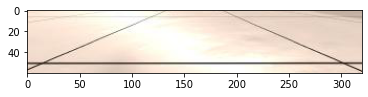

In [5]:
Rover=perception_step(Rover)

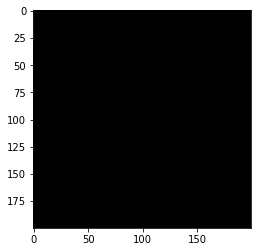

In [6]:
plt.imshow(Rover.worldmap)

In [8]:
def is_obstacles_at_the_center(Image,shape_x,shape_y):
    cropped_Image=Image.crop((0,0,(shape_x/3),(shape_y)))
    if ( np.array(cropped_Image).any(axis=-1).sum() >20) : #20 in case if noises exist
        return 1
    return 0

In [10]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

In [11]:
color_thresh(Rover.img)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [14]:
def calc_source_and_destination(img):
    dst=3
    bottom_offset=5
    croprd_image=img[90:150,:]
    plt.imshow(croprd_image)
    gry=cv2.cvtColor(croprd_image,cv2.COLOR_BGR2GRAY)
    corners=cv2.goodFeaturesToTrack(gry,5,0.01,80)
    corners=np.int0(corners)
    x=[]
    y=[]
    for i in corners:
        b,n=i.ravel()
        print(b,n)
        x.append(b)
        y.append(n)

    source =np.float32([[x[2],y[2]+60],
                      [x[3],y[3]+60],
                      [x[0],y[0]+60],
                       [x[1],y[1]+60]])         
    destination =np.float32([[img.shape[1]/2-dst,img.shape[0]-bottom_offset],
                             [img.shape[1]/2+dst,img.shape[0]-bottom_offset],
                             [img.shape[1]/2+dst,img.shape[0]-2*dst-bottom_offset],
                             [img.shape[1]/2-dst,img.shape[0]-2*dst-bottom_offset]])
    
    return source, destination 

20 49
308 52
101 13
195 6


(array([[101.,  73.],
        [195.,  66.],
        [ 20., 109.],
        [308., 112.]], dtype=float32),
 array([[157., 155.],
        [163., 155.],
        [163., 149.],
        [157., 149.]], dtype=float32))

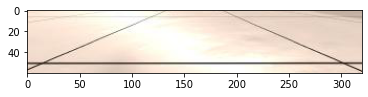

In [15]:
calc_source_and_destination(Rover.img)

In [16]:
obstacles_in_the_original_image=detect_obstecals(Rover.img) 
#get the shape of the Rover image
shape_x=Rover.img.shape[0] 
shape_y =Rover.img.shape[1] 

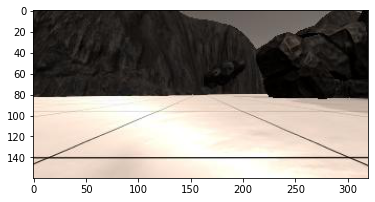

In [17]:
plt.imshow(Rover.img)

20 49
308 52
101 13
195 6


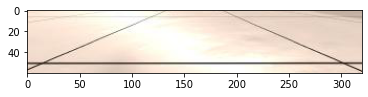

In [20]:
  source,destination =calc_source_and_destination(Rover.img)

In [ ]:
Rover.two_sides_obstacles

In [ ]:
is_obstacles_at_the_center(cropped_image,shape_x,shape_y)

In [ ]:
plt.imshow(cropped_obstacle_image)

20 49
308 52
101 13
195 6


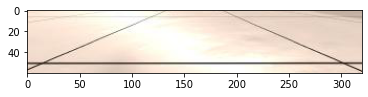

In [23]:
source,destination =calc_source_and_destination(Rover.img)
# 2) Apply perspective transform
wraped_image=perspect_transform(Rover.img,source,destination)
# 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
#identify obstecals
obstacles_image = detect_obstecals(wraped_image)

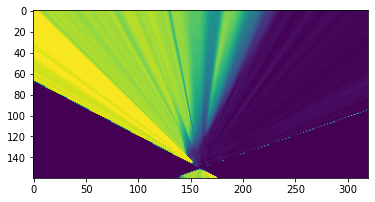

In [24]:
plt.imshow(wraped_image[:,:,0]*255)

In [29]:
def rock_thresh(img, rgb_thresh=(0, 0, 0)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                | (img[:,:,1] > rgb_thresh[1]) \
                | (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def detect_rock(image,lower=(91, 85, 84),upper=(102, 255, 255)):
    hsv_rock = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_rock,lower,upper)  
    #res = cv2.bitwise_and(image, image, mask=mask)
    detected_rock_image = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)  
    return detected_rock_image[:,:,0]

#funciton to identify the obstecals pixels
#output: 
#obstecals pixels in white
#other in black
def obstacle_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                | (img[:,:,1] < rgb_thresh[1]) \
                | (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[below_thresh] = 1
    # Return the binary image
    return color_select


def detect_obstecals(image,lower=(0, 0, 88),upper=(179, 255, 255)):
   # bgr_obstecals = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    hsv_obsteclas = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_obsteclas,lower,upper)  
    # define the kernal
    kernel = np.ones((5, 5), np.uint8)  
    #close operation
    detected_obstacle = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #open operation
    detected_obstacle = cv2.morphologyEx(detected_obstacle, cv2.MORPH_CLOSE, kernel)
    detected_obstacle_rgb = cv2.cvtColor(detected_obstacle,cv2.COLOR_BGR2RGB)  
    #invert the white and black pixels
    detected_obstacles_image =np.invert(detected_obstacle_rgb)
    return detected_obstacles_image[:,:,0]   


20 49
308 52
101 13
195 6


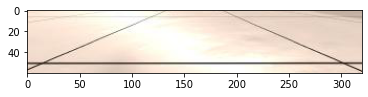

In [30]:
source,destination =calc_source_and_destination(Rover.img)
# 2) Apply perspective transform
wraped_image=perspect_transform(Rover.img,source,destination)
# 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
#identify obstecals
obstacles_image = cv2.bitwise_and(obstacle_thresh(wraped_image),wraped_image[:,:,0],mask=None)

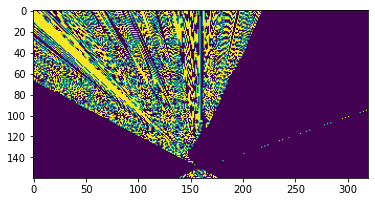

In [31]:
plt.imshow(obstacles_image)

In [32]:
Rover.vision_image[:,:,0]=obstacles_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


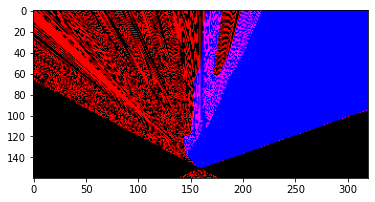

In [33]:
plt.imshow(Rover.vision_image)

In [34]:
x_rover_obstacles, y_rover_obstacles =rover_coords(obstacles_image)

C:\Users\win10\AppData\Local\Temp/ipykernel_12460/2956423917.py:123: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
C:\Users\win10\AppData\Local\Temp/ipykernel_12460/2956423917.py:124: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.

In [35]:
x_rover_obstacles

array([160., 160., 160., ...,   1.,   1.,   1.])

In [36]:
xpos =Rover.pos[0] # current Rover x position
ypos =Rover.pos[1] # current Rover y position
yaw =Rover.yaw
world_size =Rover.worldmap.shape[0] #shape[0] to get the length of the worldmap
scale =2*3 #3 is the dist
x_world_obstacles, y_world_obstecals = pix_to_world(x_rover_obstacles, y_rover_obstacles, xpos, ypos, yaw, world_size, scale)

In [37]:
Rover.worldmap[y_world_obstecals, x_world_obstacles, 0] = 250

In [38]:
Rover.worldmap[y_world_obstecals, x_world_obstacles, 0]

array([250., 250., 250., ..., 250., 250., 250.])

In [39]:
y_world_obstecals

array([0, 0, 0, ..., 3, 3, 3])

In [40]:
x_world_obstacles

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
 M = cv2.getPerspectiveTransform(source,destination)

In [46]:
 Rover.obstacle_at_the_end_of_pixel

1

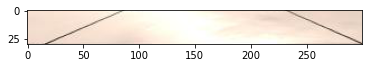

In [47]:
plt.imshow(cropped_image
          )

In [48]:
def detect_obstecals(image,lower=(0, 0, 88),upper=(179, 255, 255)):
   # bgr_obstecals = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    hsv_obsteclas = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_obsteclas,lower,upper)  
    # define the kernal
    kernel = np.ones((5, 5), np.uint8)  
    #close operation
    detected_obstacle = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #open operation
    detected_obstacle = cv2.morphologyEx(detected_obstacle, cv2.MORPH_CLOSE, kernel)
    detected_obstacle_rgb = cv2.cvtColor(detected_obstacle,cv2.COLOR_BGR2RGB)
    #detected_obstacles_image =cv2.cvtColor(detected_obstacle,cv2.COLOR_RGB2GRAY)
    #invert the white and black pixels
    detected_obstacles_image =np.invert(detected_obstacle_rgb)
    detected_obstacles_image[detected_obstacles_image>0]=255
    detected_obstacles_image[detected_obstacles_image==0]=0
    #detected_obstacles_image =cv2.cvtColor(detected_obstacles_image,cv2.COLOR_RGB2GRAY) 
    return  detected_obstacles_image 


In [49]:
def ground_thres_new(image,mask_obstacles, mask_rock ):
    mask_obstacles_or_rock =cv2.bitwise_or(mask_obstacles,mask_rock,mask=None) 
    mask_ground =np.invert(mask_obstacles_or_rock)
    return mask_ground

20 49
308 52
101 13
195 6


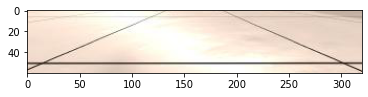

In [50]:
source,destination =calc_source_and_destination(Rover.img)
# 2) Apply perspective transform
wraped_image=perspect_transform(Rover.img,source,destination)
# 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
#identify obstecals
wraped_image_gray=wraped_image.copy()
wraped_image_gray[wraped_image_gray>0]=255
wraped_image_gray[wraped_image_gray==0]=0
obstacles_image = cv2.bitwise_and(detect_obstecals(wraped_image),wraped_image_gray,mask=None)
# obstacles_image=detect_obstecals(wraped_image)

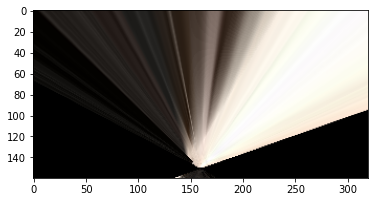

In [51]:
plt.imshow(wraped_image)

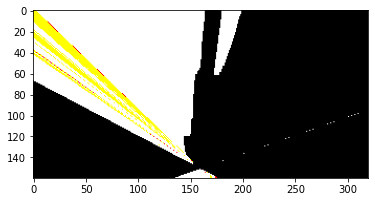

In [52]:
plt.imshow(obstacles_image)

In [72]:
    
    dst=5
    bottom_offset=5
    croprd_image=Rover.img[90:150,:]
    #plt.imshow(croprd_image)
    source=np.float32([[14,140],
                      [300,140],
                      [200,95],
                      [120,95]])
    
    destination =np.float32([[Rover.img.shape[1]/2-dst,Rover.img.shape[0]-bottom_offset],
                             [Rover.img.shape[1]/2+dst,Rover.img.shape[0]-bottom_offset],
                             [Rover.img.shape[1]/2+dst,Rover.img.shape[0]-2*dst-bottom_offset],
                             [Rover.img.shape[1]/2-dst,Rover.img.shape[0]-2*dst-bottom_offset]])
    
    #source,destination =calc_source_and_destination(Rover.img)
    # 2) Apply perspective transform
    wraped_image=perspect_transform(Rover.img,source,destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    
    wraped_image_gray=wraped_image.copy()
    wraped_image_gray[wraped_image_gray>0]=255
    wraped_image_gray[wraped_image_gray==0]=0
    #wraped_image_gray =cv2.cvtColor(wraped_image_gray,cv2.COLOR_RGB2GRAY)

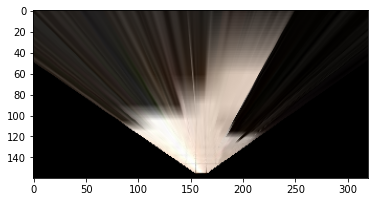

In [73]:
plt.imshow(wraped_image)

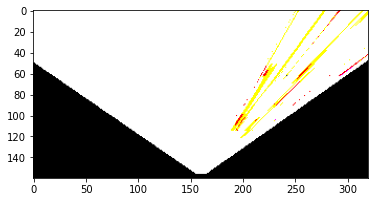

In [74]:
plt.imshow(wraped_image_gray)

In [57]:
#begin editing 
#function to calculate the source and destination point for the image wraping

#funciton to identify the rock pixels
#output: 
#rock pixels in white
#other in black

def detect_rock(image,lower=(91, 85, 84),upper=(102, 255, 255)):
    hsv_rock = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_rock,lower,upper)  
    #res = cv2.bitwise_and(image, image, mask=mask)
    detected_rock_image = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    detected_rock_image[detected_rock_image>0]=255
    detected_rock_image[detected_rock_image==0]=0
    #detected_rock_image = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    return detected_rock_image[:,:,0]




#funciton to identify the obstecals pixels
#output: 
#obstecals pixels in white
#other in black


def detect_obstecals(image,lower=(0, 0, 88),upper=(179, 255, 255)):
   # bgr_obstecals = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    hsv_obsteclas = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_obsteclas,lower,upper)  
    # define the kernal
    kernel = np.ones((5, 5), np.uint8)  
    #close operation
    detected_obstacle = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #open operation
    detected_obstacle = cv2.morphologyEx(detected_obstacle, cv2.MORPH_CLOSE, kernel)
    detected_obstacle_rgb = cv2.cvtColor(detected_obstacle,cv2.COLOR_BGR2RGB)
    #detected_obstacles_image =cv2.cvtColor(detected_obstacle,cv2.COLOR_RGB2GRAY)
    #invert the white and black pixels
    detected_obstacles_image =np.invert(detected_obstacle_rgb)
    #detected_obstacles_image =cv2.cvtColor(detected_obstacles_image,cv2.COLOR_RGB2GRAY) 
    detected_obstacles_image[detected_obstacles_image>0]=255
    detected_obstacles_image[detected_obstacles_image==0]=0
    
    return  detected_obstacles_image[:,:,0]  

In [58]:
    #identify obstecals
    obstacles_image = cv2.bitwise_and(detect_obstecals(wraped_image),wraped_image_gray,mask=None)
    #identiy rocks
    rock_image =cv2.bitwise_and(detect_rock(wraped_image),wraped_image_gray,mask=None)
    #identify ground 
    ground_image =cv2.bitwise_and(color_thresh(wraped_image),wraped_image_gray,mask=None)

    # 4) Update Rover.vision_image (this will be displayed on left side of screen)
        # Example: Rover.vision_image[:,:,0] = obstacle color-thresholded binary image
        
    #put the obstacles in the r channel
    Rover.vision_image[:,:,0]=obstacles_image #(obstacles_image*255-ground_image*255)
    
    #put the rock in the g channel
    Rover.vision_image[:,:,1]=rock_image #*255
    
    #put the ground in the b channel
    Rover.vision_image[:,:,2]=ground_image #*255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


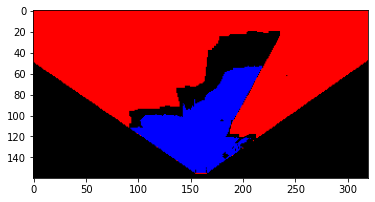

In [59]:
plt.imshow(Rover.vision_image)


In [60]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped



In [68]:
    x_rover_obstacles, y_rover_obstacles =rover_coords(obstacles_image)
    x_rover_rock, y_rover_rock =rover_coords(rock_image)
    x_rover_ground, y_rover_ground =rover_coords(ground_image)
        
    # 6) Convert rover-centric pixel values to world coordinates
    xpos =Rover.pos[0] # current Rover x position
    ypos =Rover.pos[1] # current Rover y position
    yaw =Rover.yaw
    world_size =Rover.worldmap.shape[0] #shape[0] to get the length of the worldmap
    scale =10 #3 is the dist
    x_world_obstacles, y_world_obstecals = pix_to_world(x_rover_obstacles, y_rover_obstacles, xpos, ypos, yaw, world_size, scale)
    x_world_rock, y_world_rock =pix_to_world(x_rover_rock, y_rover_rock, xpos, ypos, yaw, world_size, scale)
    x_world_ground, y_world_ground =pix_to_world(x_rover_ground, y_rover_ground,xpos, ypos, yaw, world_size, scale)
        
    # 7) Update Rover worldmap (to be displayed on right side of screen)
    Rover.worldmap[y_world_obstecals, x_world_obstacles, 0] = 30 
    Rover.worldmap[y_world_rock, x_world_rock, 0] = 0
    Rover.worldmap[y_world_rock, x_world_rock, 1] = 255  
    Rover.worldmap[y_world_ground, x_world_ground, 1]=0
    Rover.worldmap[y_world_ground, x_world_ground, 2] =255   
    Rover.worldmap[y_world_obstecals, x_world_obstacles, 2] =0

C:\Users\win10\AppData\Local\Temp/ipykernel_12460/2788212838.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
C:\Users\win10\AppData\Local\Temp/ipykernel_12460/2788212838.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.floa